In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
import os
import joblib
import json

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

from sklearn.metrics import confusion_matrix, classification_report

# Set directory
base_dir = './sets'
# Load validation set and test set
X_val = np.load(f'{base_dir}/X_val.npy')
y_val = np.load(f'{base_dir}/y_val.npy')
X_test = np.load(f'{base_dir}/X_test.npy')
y_test = np.load(f'{base_dir}/y_test.npy')

# load best sets
over_sampled_best_X_val = np.load(f'{base_dir}/over_sampled_best_X_val.npy')
under_sampled_best_X_val = np.load(f'{base_dir}/under_sampled_best_X_val.npy')
over_sampled_best_X_test = np.load(f'{base_dir}/over_sampled_best_X_test.npy')
under_sampled_best_X_test = np.load(f'{base_dir}/under_sampled_best_X_test.npy')

# make output directory
output_dir = './shallow_nn_out'
os.makedirs(output_dir, exist_ok=True)

n_features = X_val.shape[1]
n_best_over_features = over_sampled_best_X_val.shape[1]
n_best_under_features = under_sampled_best_X_val.shape[1]

# Hyper tuning parameters 

In [56]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,)],  # Number of hidden units
    'activation': ['relu', 'tanh', 'logistic'],  # Activation function
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength (L2 penalty)
    'learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
}    

In [57]:

def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

# Hyper tunning to each specific set

## Under Sampling - No selection

In [58]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='under_no_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



Reloading Tuner from ./shallow_nn_out/under_no_sel_shallow_nn/tuner0.json


In [59]:
# training data
x_train = np.load(f'{base_dir}/under_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/under_sampled_y_train.npy')
tuner.search(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/under_sampled_no_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/under_sampled_no_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/under_sampled_no_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/under_sampled_no_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



Found:
- units: 128
- activation: sigmoid
- learning_rate: 0.001

Epoch 1/70
 1/14 ━━━━━━━━━━━━━━━━━━━━ 7s 597ms/step - accuracy: 0.5938 - loss: 0.6130

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.7536 - loss: 0.5594 - val_accuracy: 0.9979 - val_loss: 0.4649
Epoch 2/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9197 - loss: 0.3737 - val_accuracy: 0.9991 - val_loss: 0.3373
Epoch 3/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8894 - loss: 0.3174 - val_accuracy: 0.9993 - val_loss: 0.2427
Epoch 4/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9137 - loss: 0.2486 - val_accuracy: 0.9992 - val_loss: 0.1972
Epoch 5/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9190 - loss: 0.2341 - val_accuracy: 0.9975 - val_loss: 0.1989
Epoch 6/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9231 - loss: 0.2104 - val_accuracy: 0.9941 - val_loss: 0.1780
Epoch 7/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9278 - loss: 0.2038 - val_accuracy: 0.9920 - val_loss: 0.1653
Epoch 8/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9381 - loss: 0.1790 - val_accuracy: 0.9896 - val_loss: 0.

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 749us/step - accuracy: 0.9744 - loss: 0.1240


# Plot of Training and Validation Accuracy/Loss

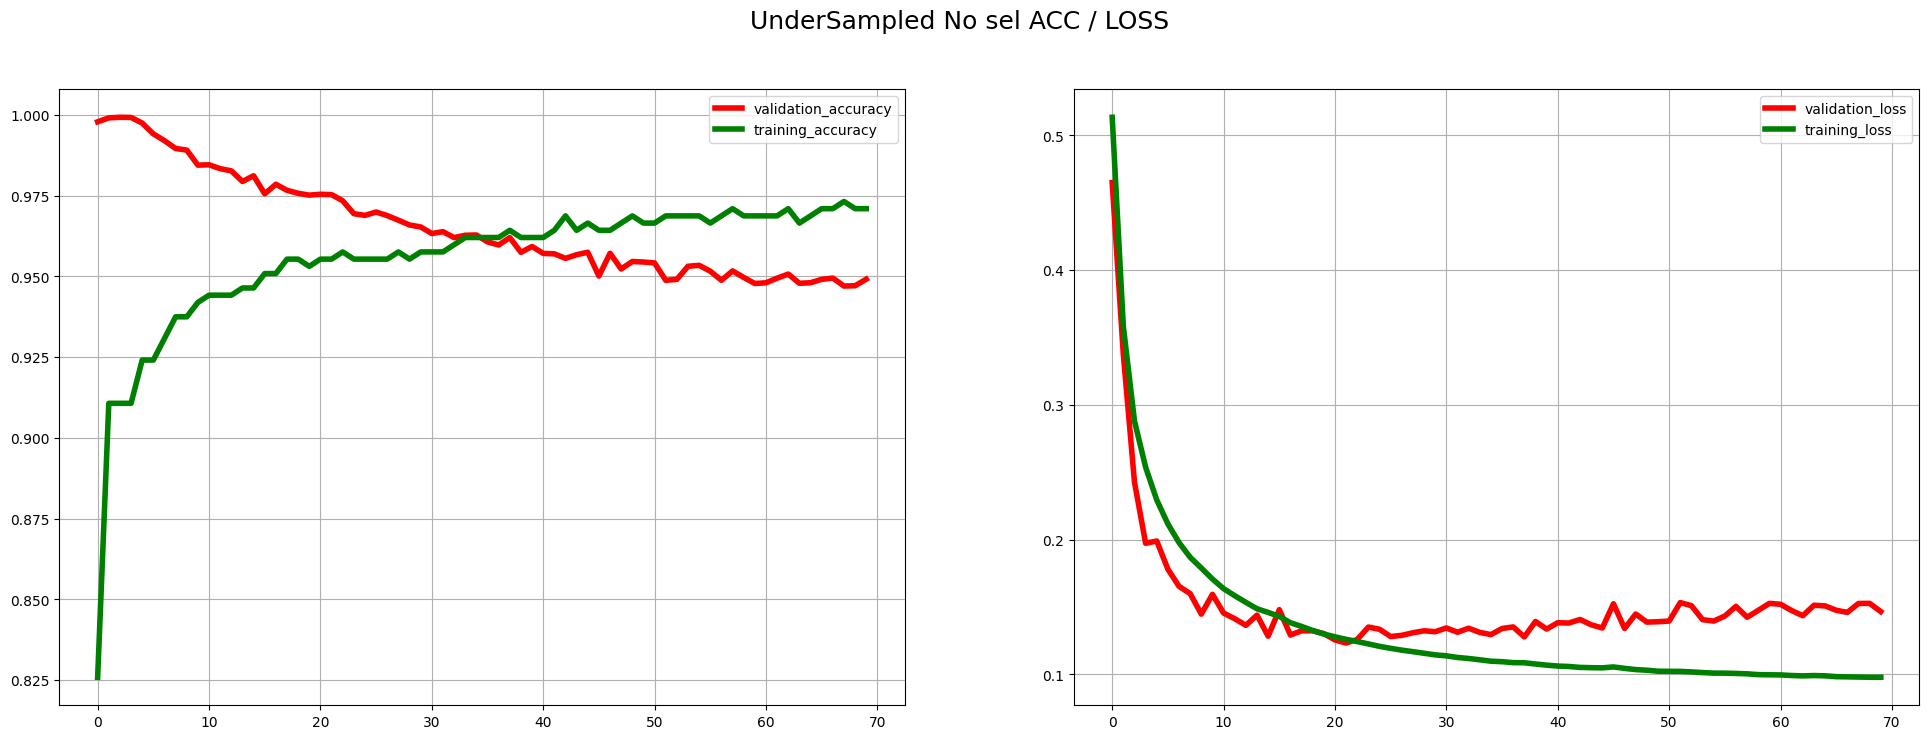

In [60]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("UnderSampled No sel ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 573us/step
[[97019  2492]
 [   20   152]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     99511
         1.0       0.06      0.88      0.11       172

    accuracy                           0.97     99683
   macro avg       0.53      0.93      0.55     99683
weighted avg       1.00      0.97      0.99     99683



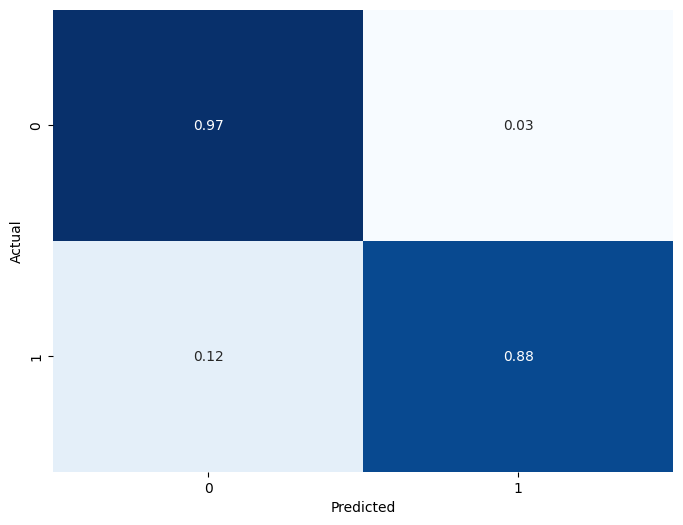

In [61]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Over Sampling - No selection

In [62]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='over_no_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



Reloading Tuner from ./shallow_nn_out/over_no_sel_shallow_nn/tuner0.json


In [63]:
# training data
x_train = np.load(f'{base_dir}/over_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/over_sampled_y_train.npy')
tuner.search(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/over_sampled_no_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/over_sampled_no_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/over_sampled_no_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/over_sampled_no_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



Found:
- units: 224
- activation: relu
- learning_rate: 0.01

Epoch 1/70


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 925us/step - accuracy: 0.9892 - loss: 0.0409 - val_accuracy: 0.9979 - val_loss: 0.0125
Epoch 2/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 866us/step - accuracy: 0.9983 - loss: 0.0138 - val_accuracy: 0.9989 - val_loss: 0.0118
Epoch 3/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 925us/step - accuracy: 0.9986 - loss: 0.0180 - val_accuracy: 0.9987 - val_loss: 0.0216
Epoch 4/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 901us/step - accuracy: 0.9994 - loss: 0.0077 - val_accuracy: 0.9991 - val_loss: 0.0155
Epoch 5/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 796us/step - accuracy: 0.9993 - loss: 0.0081 - val_accuracy: 0.9992 - val_loss: 0.0171
Epoch 6/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 893us/step - accuracy: 0.9996 - loss: 0.0041 - val_accuracy: 0.9992 - val_loss: 0.0220
Epoch 7/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 852us/step - accuracy: 0.9996 - loss: 0.0056 - val_accuracy: 0.9993 - val_loss: 0.0193
Epoch 8/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 881us/step - accuracy: 0.9996 - loss: 0.00

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 718us/step - accuracy: 0.9985 - loss: 0.0214


# Plot of Training and Validation Accuracy/Loss

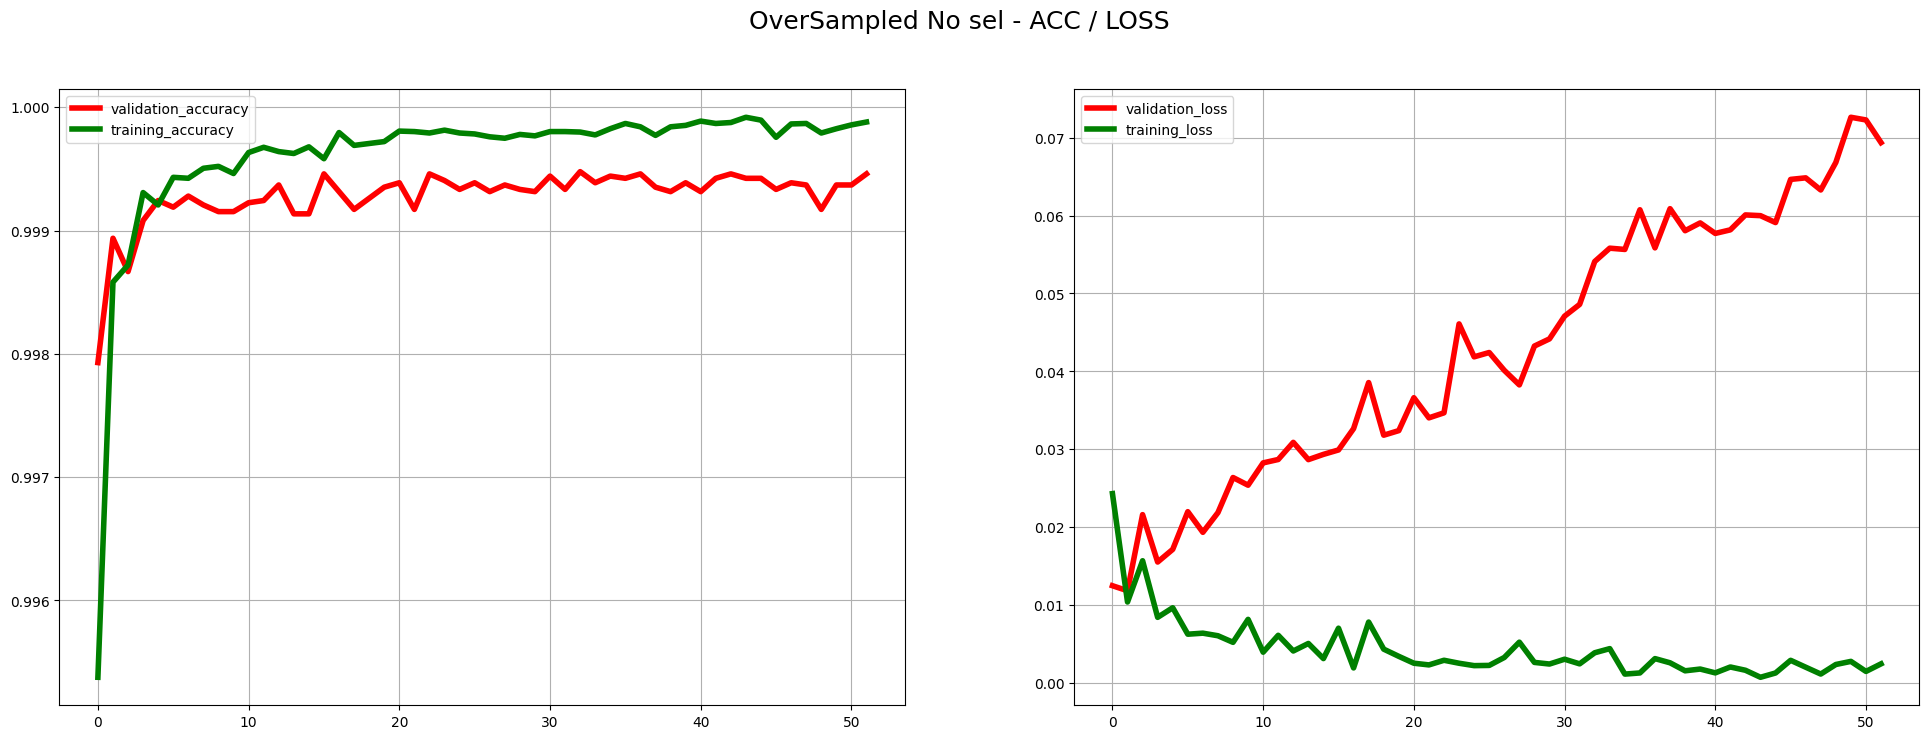

In [64]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 563us/step
[[99384   127]
 [   31   141]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99511
         1.0       0.53      0.82      0.64       172

    accuracy                           1.00     99683
   macro avg       0.76      0.91      0.82     99683
weighted avg       1.00      1.00      1.00     99683



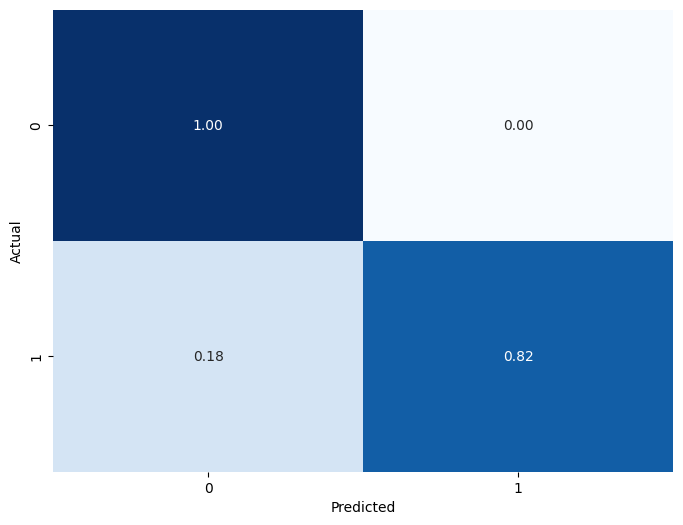

In [65]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# New builder

In [66]:

def build_best_under_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_best_under_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_best_under_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='under_best_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

Reloading Tuner from ./shallow_nn_out/under_best_sel_shallow_nn/tuner0.json


## Under Sampling - Best selection

In [67]:
# training data
x_train = np.load(f'{base_dir}/under_sampled_best_X_train.npy')
y_train = np.load(f'{base_dir}/under_sampled_y_train.npy')

tuner.search(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/under_sampled_best_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/under_sampled_best_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/under_sampled_best_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(under_sampled_best_X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/under_sampled_best_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



Found:
- units: 256
- activation: sigmoid
- learning_rate: 0.001

Epoch 1/70


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.5197 - loss: 0.7303 - val_accuracy: 0.9889 - val_loss: 0.5306
Epoch 2/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9041 - loss: 0.3855 - val_accuracy: 0.9993 - val_loss: 0.2674
Epoch 3/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9073 - loss: 0.2847 - val_accuracy: 0.9991 - val_loss: 0.2237
Epoch 4/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9199 - loss: 0.2463 - val_accuracy: 0.9988 - val_loss: 0.1956
Epoch 5/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9015 - loss: 0.2348 - val_accuracy: 0.9959 - val_loss: 0.2045
Epoch 6/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9245 - loss: 0.2106 - val_accuracy: 0.9957 - val_loss: 0.1660
Epoch 7/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9191 - loss: 0.2120 - val_accuracy: 0.9916 - val_loss: 0.1763
Epoch 8/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9370 - loss: 0.1904 - val_accuracy: 0.9915 - val_loss: 0.

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 685us/step - accuracy: 0.9702 - loss: 0.1307


# Plot of Training and Validation Accuracy/Loss

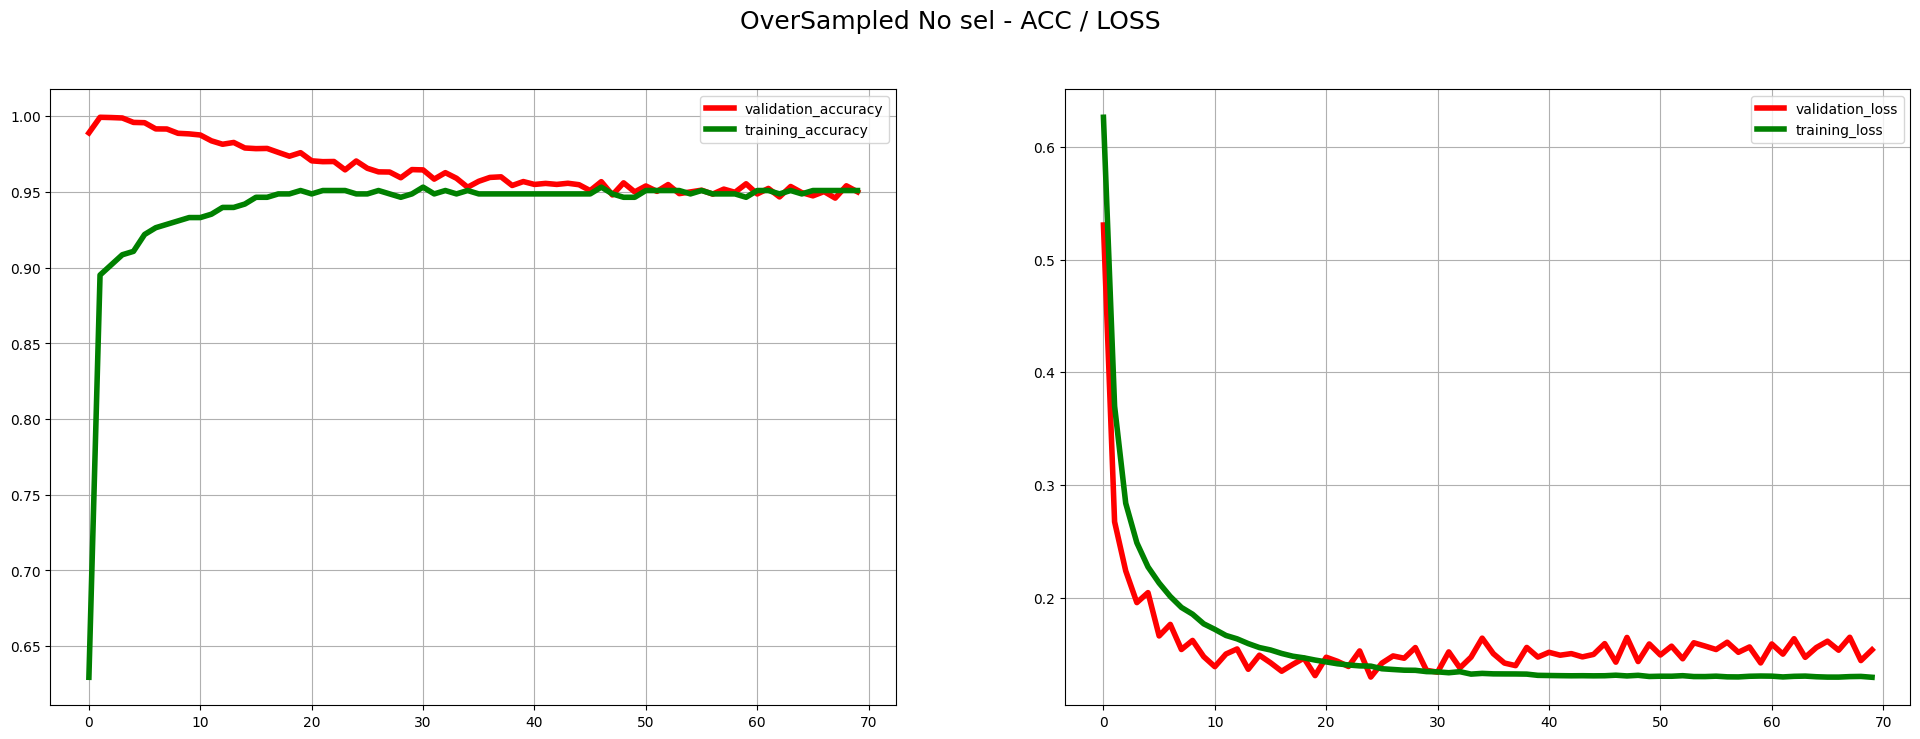

In [68]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 631us/step
[[96584  2927]
 [   22   150]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     99511
         1.0       0.05      0.87      0.09       172

    accuracy                           0.97     99683
   macro avg       0.52      0.92      0.54     99683
weighted avg       1.00      0.97      0.98     99683



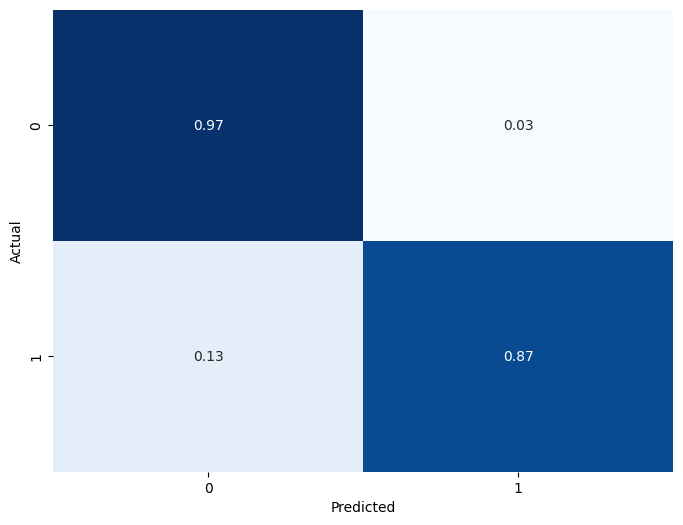

In [69]:
y_pred = model.predict(under_sampled_best_X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# New Builder

In [70]:

def build_best_over_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_best_over_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_best_under_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='over_best_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

Reloading Tuner from ./shallow_nn_out/over_best_sel_shallow_nn/tuner0.json


## Over Sampling - Best selection

In [71]:
# training data
x_train = np.load(f'{base_dir}/over_sampled_best_X_train.npy')
y_train = np.load(f'{base_dir}/over_sampled_y_train.npy')
print("GPUS: ", tf.config.list_physical_devices('GPU'))

tuner.search(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/over_sampled_best_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/over_sampled_best_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/over_sampled_best_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(under_sampled_best_X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/over_sampled_best_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



GPUS:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found:
- units: 192
- activation: sigmoid
- learning_rate: 0.01

Epoch 1/70


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 875us/step - accuracy: 0.9624 - loss: 0.0987 - val_accuracy: 0.9950 - val_loss: 0.0163
Epoch 2/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 899us/step - accuracy: 0.9981 - loss: 0.0077 - val_accuracy: 0.9983 - val_loss: 0.0093
Epoch 3/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 904us/step - accuracy: 0.9988 - loss: 0.0049 - val_accuracy: 0.9980 - val_loss: 0.0098
Epoch 4/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 852us/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9988 - val_loss: 0.0077
Epoch 5/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 864us/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9990 - val_loss: 0.0067
Epoch 6/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 871us/step - accuracy: 0.9992 - loss: 0.0039 - val_accuracy: 0.9989 - val_loss: 0.0074
Epoch 7/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 859us/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9986 - val_loss: 0.0085
Epoch 8/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 867us/step - accuracy: 0.9995 - loss: 0.00

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 761us/step - accuracy: 0.9985 - loss: 0.0095


# Plot of Training and Validation Accuracy/Loss

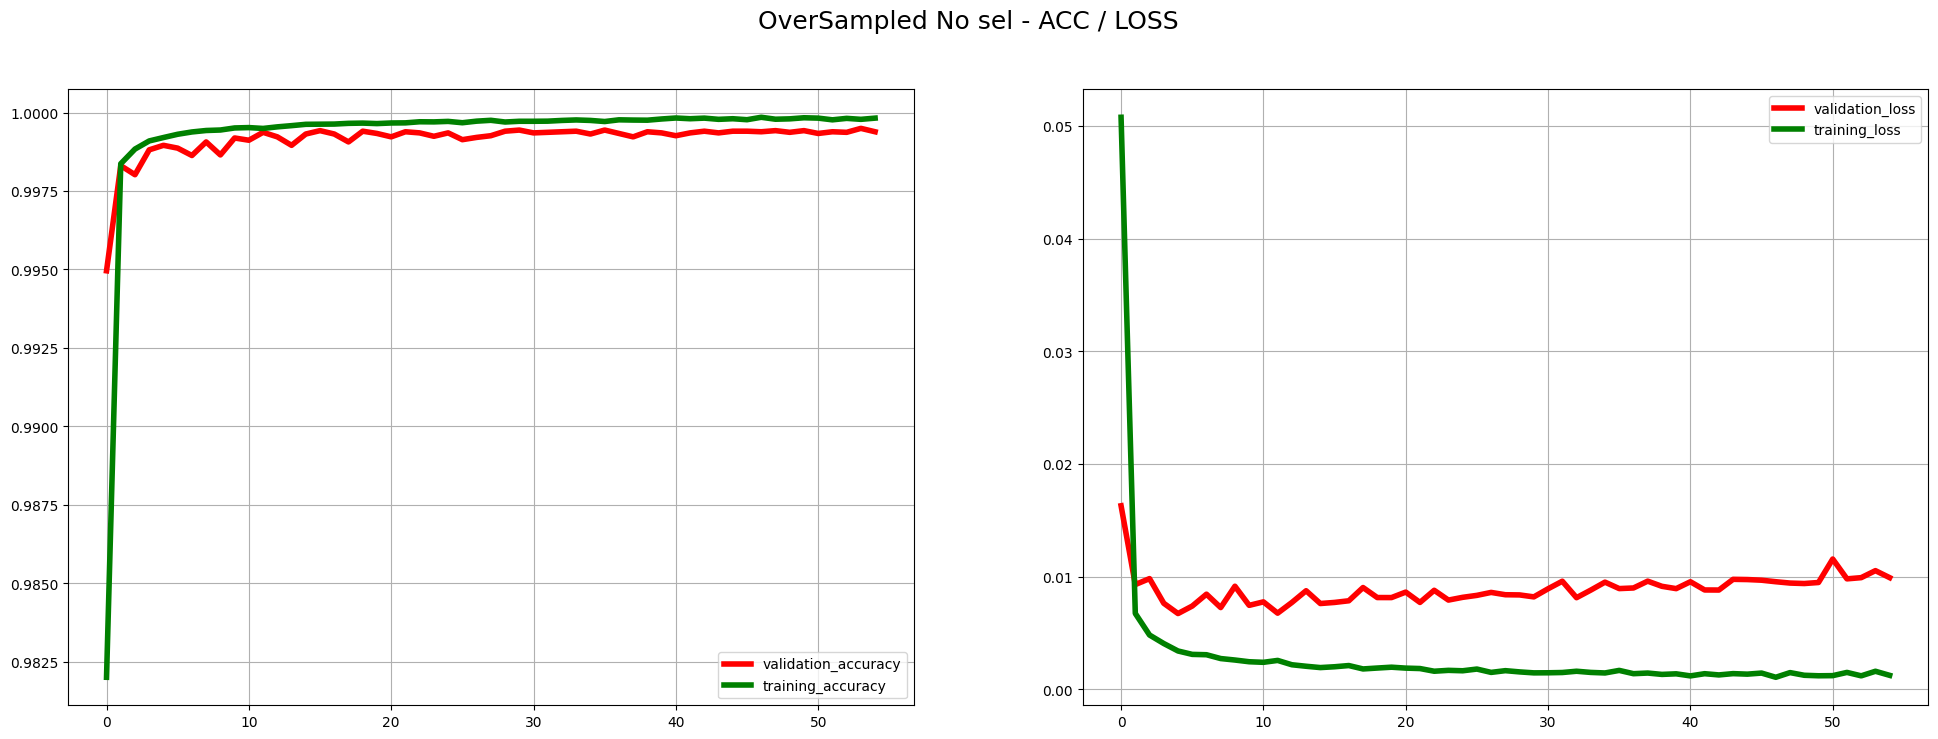

In [72]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 618us/step
[[99381   130]
 [   35   137]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99511
         1.0       0.51      0.80      0.62       172

    accuracy                           1.00     99683
   macro avg       0.76      0.90      0.81     99683
weighted avg       1.00      1.00      1.00     99683



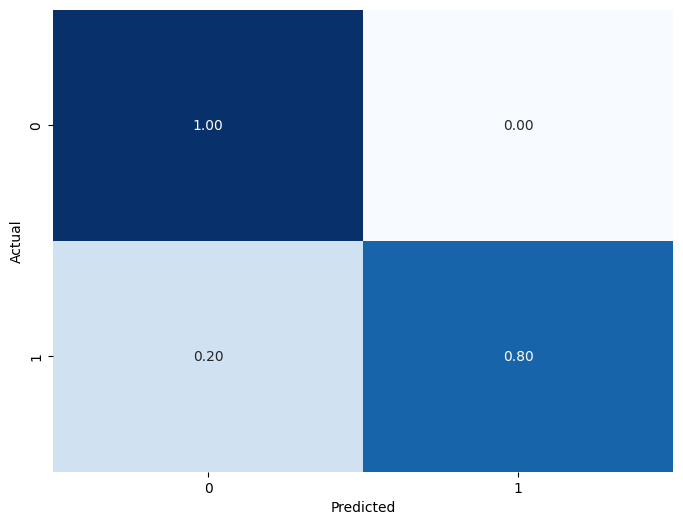

In [73]:
y_pred = model.predict(over_sampled_best_X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()